In [1]:
import torch, pytorch_lightning as pl
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from torch.utils.data import DataLoader
from tensordict import TensorDict
from causica.lightning.modules.deci_module import DECIModule
from causica.lightning.data_modules.deci_data_module import DECIDataModule
from causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.tensordict_utils import identity, tensordict_shapes
from networkx.drawing.nx_pydot import to_pydot

In [3]:
df = pd.read_csv("encoded_clean_data3.csv")

df = df.iloc[:, 1:-17]
df = df.apply(pd.to_numeric, errors="coerce")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.apply(lambda col: col.fillna(col.mean()), axis=0)
df = df.dropna(axis=1, how="all")
df = df.dropna(axis=0, how="any")

df = df.sample(frac=0.3, random_state=42)

In [4]:
tensor = torch.tensor(df.to_numpy(np.float32))
td_all = TensorDict(
    {c: tensor[:, i:i+1] for i, c in enumerate(df.columns)},
    batch_size=[len(df)]
)

class SimpleDM(DECIDataModule):
    def __init__(self, td: TensorDict, batch=256):
        super().__init__()
        self._train = td
        self._test  = td
        self._bs    = batch
        self._shapes = tensordict_shapes(td)
        self._types  = {k: VariableTypeEnum.CONTINUOUS for k in td.keys()}
        self._cols   = {k: [k] for k in td.keys()}

    # Lightning
    def train_dataloader(self):
        return DataLoader(self._train, batch_size=self._bs,
                          shuffle=True, collate_fn=identity, drop_last=True)

    @property
    def dataset_name(self):    return "user_dataset"
    @property
    def dataset_train(self):   return self._train
    @property
    def dataset_test(self):    return self._test
    @property
    def variable_types(self):  return self._types
    @property
    def variable_shapes(self): return self._shapes
    @property
    def column_names(self):    return self._cols

dm = SimpleDM(td_all, batch=256)

model = DECIModule(prior_sparsity_lambda=5.0)

trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1, max_epochs=100, log_every_n_steps=25,
)
trainer.fit(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type                  | Params
------------------------------------------------------
0 | auglag_loss | AugLagLossCalculator  | 0     
1 | sem_module  | SEMDistributionModule | 71.4 K
------------------------------------------------------
70.2 K    Trainable params
1.2 K     Non-trainable params
71.4 K    Total params
0.286     Total estimated model params size (MB)
d:\Anaconda\envs\deci\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/66 [00:00<?, ?it/s] 

d:\Anaconda\envs\deci\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: You called `self.log('num_edges', ...)` in your `training_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'num_edges': ...})` instead.


Epoch 1:   0%|          | 0/66 [00:00<?, ?it/s, v_num=16]         

d:\Anaconda\envs\deci\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: You called `self.log('num_lr_updates', ...)` in your `on_train_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'num_lr_updates': ...})` instead.
d:\Anaconda\envs\deci\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: You called `self.log('outer_opt_counter', ...)` in your `on_train_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics(

Epoch 99: 100%|██████████| 66/66 [00:16<00:00,  3.99it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, v_num=16]


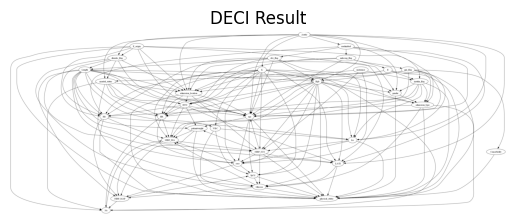

In [27]:
trainer.save_checkpoint("saved_models/deci_model.ckpt")
# model = DECIModule.load_from_checkpoint("saved_models/deci_model.ckpt")
# model.eval()

with torch.no_grad():
    sem = model.sem_module().sample(torch.Size([1]))[0]
    adj = sem.graph.cpu().numpy()

edges_prob = np.zeros_like(adj, dtype=np.float32)
for _ in range(2000):
    a = model.sem_module().sample(torch.Size([]))[0].graph.cpu().numpy()
    edges_prob += a
edges_prob /= 2000

w = 0.99
mask = edges_prob >= w
adj_w = adj * mask

G = nx.from_numpy_array(adj_w, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, {i: df.columns[i] for i in range(len(df.columns))})

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/deci_result.png")

img = plt.imread("figures/deci_result.png")
plt.imshow(img)
plt.axis("off")
plt.title("DECI Result")
plt.show()

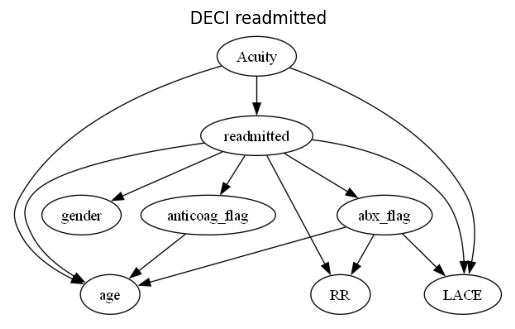

In [28]:
target = "readmitted"
neighbors = set(G.predecessors(target)) | set(G.successors(target)) | {target}

G_sub = G.subgraph(neighbors).copy()
pydot_graph = to_pydot(G_sub)
pydot_graph.write_png("figures/deci_re.png")

img = plt.imread("figures/deci_re.png")
plt.imshow(img)
plt.axis("off")
plt.title("DECI readmitted")
plt.show()

2. top20

In [8]:
features1 = [
    "physical_status", "Length", "LACE", "Comorbidity", "age", "BUN",
    "NIBP_MAP", "E_origin", "WBC", "HR", "admission_location", "insurance",
    "NIBP_DIA", "Acuity", "Hgb", "NIBP_SYS", "Glucose", "SpO2", "readmitted"
]

df1 = df[features1]

In [9]:
tensor = torch.tensor(df1.to_numpy(np.float32))
td_all1 = TensorDict(
    {c: tensor[:, i:i+1] for i, c in enumerate(df1.columns)},
    batch_size=[len(df1)]
)

dm1 = SimpleDM(td_all1, batch=256)

model1 = DECIModule(prior_sparsity_lambda=5.0)

trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1, max_epochs=80, log_every_n_steps=25,
)
trainer.fit(model1, datamodule=dm1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type                  | Params
------------------------------------------------------
0 | auglag_loss | AugLagLossCalculator  | 0     
1 | sem_module  | SEMDistributionModule | 27.5 K
------------------------------------------------------
27.1 K    Trainable params
361       Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
d:\Anaconda\envs\deci\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 79: 100%|██████████| 66/66 [00:19<00:00,  3.35it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 66/66 [00:19<00:00,  3.35it/s, v_num=17]


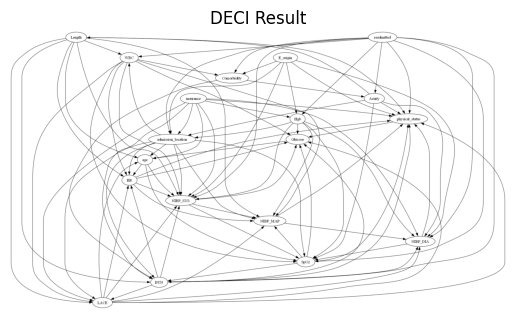

In [25]:
trainer.save_checkpoint("saved_models/deci_model2.ckpt")
# model1 = DECIModule.load_from_checkpoint("saved_models/deci_model2.ckpt")
# model1.eval()

with torch.no_grad():
    sem = model1.sem_module().sample(torch.Size([1]))[0]
    adj = sem.graph.cpu().numpy()

edges_prob = np.zeros_like(adj, dtype=np.float32)
for _ in range(2000):
    a = model1.sem_module().sample(torch.Size([]))[0].graph.cpu().numpy()
    edges_prob += a
edges_prob /= 2000

w = 0.99
mask = edges_prob >= w
adj_w = adj * mask

G = nx.from_numpy_array(adj_w, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, {i: df1.columns[i] for i in range(len(df1.columns))})

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/deci_result2.png")

img = plt.imread("figures/deci_result2.png")
plt.imshow(img)
plt.axis("off")
plt.title("DECI Result")
plt.show()

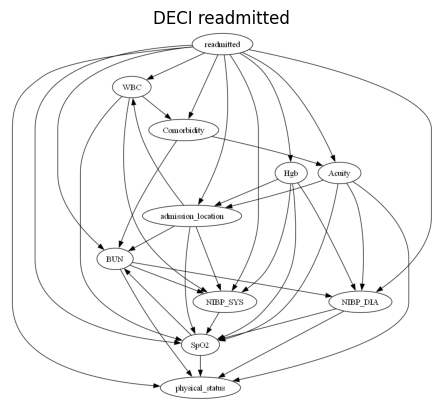

In [26]:
target = "readmitted"
neighbors = set(G.predecessors(target)) | set(G.successors(target)) | {target}

G_sub = G.subgraph(neighbors).copy()
pydot_graph = to_pydot(G_sub)
pydot_graph.write_png("figures/deci_re2.png")

img = plt.imread("figures/deci_re2.png")
plt.imshow(img)
plt.axis("off")
plt.title("DECI readmitted")
plt.show()

3. top10

In [12]:
features2 = [
    "physical_status", "Length", "LACE", "Comorbidity", "age", "BUN",
    "NIBP_MAP", "E_origin", "WBC", "readmitted"
]

df2 = df[features2]

In [13]:
tensor = torch.tensor(df2.to_numpy(np.float32))
td_all2 = TensorDict(
    {c: tensor[:, i:i+1] for i, c in enumerate(df2.columns)},
    batch_size=[len(df2)]
)

dm2 = SimpleDM(td_all2, batch=256)

model2 = DECIModule(prior_sparsity_lambda=5.0)

trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1, max_epochs=80, log_every_n_steps=25,
)
trainer.fit(model2, datamodule=dm2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type                  | Params
------------------------------------------------------
0 | auglag_loss | AugLagLossCalculator  | 0     
1 | sem_module  | SEMDistributionModule | 19.4 K
------------------------------------------------------
19.3 K    Trainable params
100       Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
d:\Anaconda\envs\deci\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 79: 100%|██████████| 66/66 [00:06<00:00, 10.98it/s, v_num=18]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 66/66 [00:06<00:00, 10.95it/s, v_num=18]


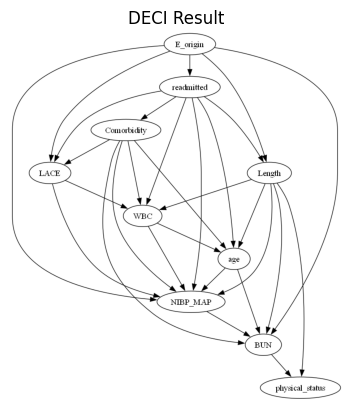

In [23]:
trainer.save_checkpoint("saved_models/deci_model3.ckpt")
# model2 = DECIModule.load_from_checkpoint("saved_models/deci_model3.ckpt")
# model2.eval()

with torch.no_grad():
    sem = model2.sem_module().sample(torch.Size([1]))[0]
    adj = sem.graph.cpu().numpy()

edges_prob = np.zeros_like(adj, dtype=np.float32)
for _ in range(2000):
    a = model2.sem_module().sample(torch.Size([]))[0].graph.cpu().numpy()
    edges_prob += a
edges_prob /= 2000

w = 0.99
mask = edges_prob >= w
adj_w = adj * mask

G = nx.from_numpy_array(adj_w, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, {i: df2.columns[i] for i in range(len(df2.columns))})

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/deci_result3.png")

img = plt.imread("figures/deci_result3.png")
plt.imshow(img)
plt.axis("off")
plt.title("DECI Result")
plt.show()

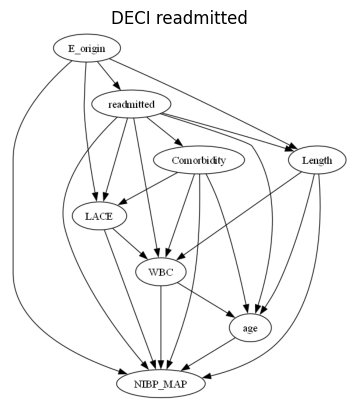

In [24]:
target = "readmitted"
neighbors = set(G.predecessors(target)) | set(G.successors(target)) | {target}

G_sub = G.subgraph(neighbors).copy()
pydot_graph = to_pydot(G_sub)
pydot_graph.write_png("figures/deci_re3.png")

img = plt.imread("figures/deci_re3.png")
plt.imshow(img)
plt.axis("off")
plt.title("DECI readmitted")
plt.show()

4. top5

In [18]:
features3 = [
    "physical_status", "Length", "LACE", "Comorbidity", "age", "readmitted"
]

df3 = df[features3]

In [19]:
tensor = torch.tensor(df3.to_numpy(np.float32))
td_all3 = TensorDict(
    {c: tensor[:, i:i+1] for i, c in enumerate(df3.columns)},
    batch_size=[len(df3)]
)

dm3 = SimpleDM(td_all3, batch=256)

model3 = DECIModule(prior_sparsity_lambda=5.0)

trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1, max_epochs=80, log_every_n_steps=25,
)
trainer.fit(model3, datamodule=dm3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type                  | Params
------------------------------------------------------
0 | auglag_loss | AugLagLossCalculator  | 0     
1 | sem_module  | SEMDistributionModule | 18.4 K
------------------------------------------------------
18.4 K    Trainable params
36        Non-trainable params
18.4 K    Total params
0.074     Total estimated model params size (MB)
d:\Anaconda\envs\deci\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 79: 100%|██████████| 66/66 [00:03<00:00, 18.33it/s, v_num=19]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 66/66 [00:03<00:00, 18.24it/s, v_num=19]


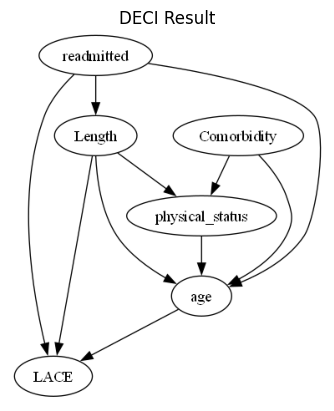

In [22]:
trainer.save_checkpoint("saved_models/deci_model4.ckpt")
# model3 = DECIModule.load_from_checkpoint("saved_models/deci_model4.ckpt")
# model3.eval()

with torch.no_grad():
    sem = model3.sem_module().sample(torch.Size([1]))[0]
    adj = sem.graph.cpu().numpy()

edges_prob = np.zeros_like(adj, dtype=np.float32)
for _ in range(2000):
    a = model3.sem_module().sample(torch.Size([]))[0].graph.cpu().numpy()
    edges_prob += a
edges_prob /= 2000

w = 0.99
mask = edges_prob >= w
adj_w = adj * mask

G = nx.from_numpy_array(adj_w, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, {i: df3.columns[i] for i in range(len(df3.columns))})

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/deci_result4.png")

img = plt.imread("figures/deci_result4.png")
plt.imshow(img)
plt.axis("off")
plt.title("DECI Result")
plt.show()

DECI learns an approximate distribution 𝑞(𝐺) over graphs using variational inference.

This allows DECI to:

Sample many possible graphs, each different.

Estimate edge probabilities by sampling multiple times.

Control sparsity and uncertainty more naturally.

That's why we get different graphs every time